<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/BoxPlots_OneHot_Scaling_KNN_2020_08_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup env


In [1]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# test, peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# test, modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27 12:01 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27 12:01 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27 12:01 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27 12:01 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27 12:01 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27 12:01 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27 12:01 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27 12:01 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27 12:01 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27 12:01 9_soul-groove9_105_beat_4-4.mid
total 49
-rw------- 1 root root 28586 Aug 18 21:35 data_prep.py
drwx------ 2 root root  4096 May 10 13:31 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root  8459 Aug 18 22:03 visualizations.py


## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [4]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [5]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 1.9MB/s 


In [6]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp

>> LOADING custom module, when: 2020-09-22 20:01:31.455941, module name: stats_n_features
>> LOADING custom module, when: 2020-09-22 20:01:31.456949, module name: data_prep


In [7]:
# imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np


# object that provides colours for charts
from itertools import cycle



In [8]:
# testing auto reload of modules 
dp.test_function_call('bling')

Test function in data_prep.py called and worked! when: 2020-09-22 20:01:31.505829,  param:bling


In [9]:
import stats_n_features as sf

In [10]:
sf.test_function_call('hello')

Test function in stats_n_features called and worked! when: 2020-09-22 20:01:31.544401,  param:hello


## Pandas display options

In [11]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load single file

In [12]:
test_1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'

# Test latest loading code

Loading code now pulls everything into dict of structures with the following layout ..
* PerformanceData = namedtuple('PerformanceData' , 'drummer_id file_df file_wrapper tools stats_df tight_df')

In [13]:
#dp.load_meta_file()

In [14]:
my_data = dp.load_all_data()

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

In [15]:
all_drummer_data = my_data

style_filter = "1_funk-groove1"  # first style to experiment with

for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  if style_filter in file_name:
    print('DrummerID: {}'.format(perf_data.drummer_id))
    print('File: {}'.format(file_name))
    display(perf_data.tight_df.head(5))
    #display(perf_data.stats_df)

DrummerID: drummer1
File: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

DrummerID: drummer5
File: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                kick        39            9                1
           1                  hh        67           15                1
           3                kick        41          -14                3
           3                  hh        58           18                3
           4                kick         6          -16                4

DrummerID: drummer7
File: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/1_funk-groove1_138_beat_4-4.mid


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                               
1          1                 kick        47            0                1
           1                   hh       113            0                1
           3                   hh        55            1                3
           3                 kick        43            5                3
           5                snare       108           25                5

DrummerID: drummer8
File: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/1_funk-groove1_138_beat_4-4.mid


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                kick        67            0                1
           1                  hh        40            0                1
           3                kick        64          -30                3
           3                  hh        37          -12                3
           5                  hh        83          -12                5

# Pick out a file, or two

In [16]:
# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'


test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()

df2 = test_data = all_drummer_data[key2].tight_df.copy()


In [17]:
df1.head()
df2.head()

note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                kick        39            9                1
           1                  hh        67           15                1
           3                kick        41          -14                3
           3                  hh        58           18                3
           4                kick         6          -16                4

## Pull out notes in 1st bar
Using technique from..
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html

In [18]:
# pull out notes in 1st bar
display(df1.xs(9, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,kick,60,-25,1
1,hh,54,-11,1
1,snare,33,47,1
3,kick,60,-25,3
3,hh,38,-17,3
5,snare,97,-20,5
5,hh,70,-17,5
7,hh,38,-8,7
8,snare,99,-16,8


# Descriptive statistics

Check out..
* https://realpython.com/python-statistics/#measures-of-central-tendency


## Summary metrics by instrument

In [19]:
print(' stats for: {}'.format(key1))
df1.describe()
#df1.groupby(['bar_beat_number', 'note'])['beat_offset'].count()
print(' stats for: {}'.format(key2))
df2.describe()

 stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,velocity,beat_offset,bar_beat_number
count,259.000000,259.000000,259.000000
mean,59.023166,-8.382239,7.528958
std,23.861508,16.705284,4.585338
min,8.000000,-58.000000,1.000000
25%,44.000000,-17.000000,3.000000
50%,52.000000,-7.000000,8.000000
75%,65.500000,1.500000,11.000000
max,127.000000,55.000000,16.000000


 stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid


,velocity,beat_offset,bar_beat_number
count,297.000000,297.000000,297.000000
mean,57.993266,8.774411,8.124579
std,30.944260,18.573438,4.639137
min,6.000000,-58.000000,1.000000
25%,40.000000,-4.000000,3.000000
50%,46.000000,11.000000,9.000000
75%,74.000000,22.000000,12.000000
max,127.000000,46.000000,16.000000


## Variance metrics

In [20]:
import statistics
print('variance stats for: {}'.format(key1))
print('  vel: {}'.format(statistics.variance(df1.velocity)))
print('  off: {}'.format(statistics.variance(df1.beat_offset)))


print('variance stats for: {}'.format(key2))
print('  vel: {}'.format(statistics.variance(df2.velocity)))
print('  off: {}'.format(statistics.variance(df2.beat_offset)))


variance stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
  vel: 569.371554278531
  off: 279.0665050432492
variance stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
  vel: 957.5472517972518
  off: 344.9725862225862


# Plotting: boxploty stuffs

Seaborn, boxplot type stuffs...
* https://cmdlinetips.com/2019/03/how-to-make-grouped-boxplots-in-python-with-seaborn/
* https://seaborn.pydata.org/generated/seaborn.stripplot.html
* https://monashdatafluency.github.io/python-workshop-base/modules/plotting_with_ggplot/
* https://plotnine.readthedocs.io/en/stable/index.html
* https://www.kaggle.com/residentmario/grammar-of-graphics-with-plotnine-optional/
* https://www.dummies.com/education/math/statistics/what-a-boxplot-can-tell-you-about-a-statistical-data-set/

.. and stuff to consider when creating boxplots...
* https://www.data-to-viz.com/caveat/boxplot.html

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Stats comparison per instrument across 2 songs

In [22]:
print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


In [23]:
print('stats for: {}'.format(key2))
df2['beat_offset'].groupby(df2['note']).describe()
df2['velocity'].groupby(df2['note']).describe()

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,128.0,15.640625,15.394924,-31.0,6.0,19.0,26.00,46.0
kick,68.0,-3.985294,17.289884,-49.0,-14.0,-4.5,8.25,35.0
snare,101.0,8.663366,18.675266,-58.0,-2.0,11.0,22.00,38.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,128.0,67.437500,25.019284,33.0,48.0,59.0,82.25,125.0
kick,68.0,31.955882,12.393347,6.0,21.0,36.0,43.00,48.0
snare,101.0,63.554455,36.469844,10.0,39.0,46.0,105.00,127.0


# Boxplots: Same song diff drummers
NOTE: this is broken! Eoghan told me I can't mix two different features on the same chart like this, it's not done, and it's confusing. Need to split velocity and offsets into different charts!!

See...
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


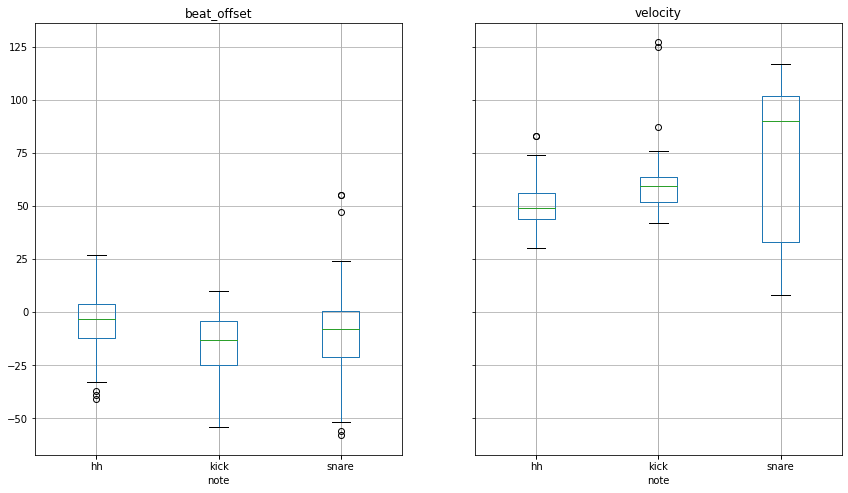

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,128.0,15.640625,15.394924,-31.0,6.0,19.0,26.00,46.0
kick,68.0,-3.985294,17.289884,-49.0,-14.0,-4.5,8.25,35.0
snare,101.0,8.663366,18.675266,-58.0,-2.0,11.0,22.00,38.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,128.0,67.437500,25.019284,33.0,48.0,59.0,82.25,125.0
kick,68.0,31.955882,12.393347,6.0,21.0,36.0,43.00,48.0
snare,101.0,63.554455,36.469844,10.0,39.0,46.0,105.00,127.0


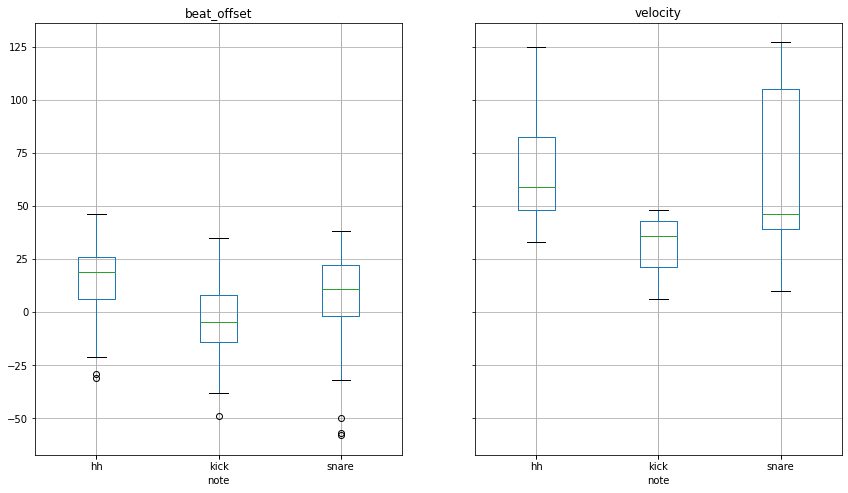

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,123.0,5.406504,13.446212,-29.0,-4.00,6.0,13.50,38.0
kick,56.0,0.375000,15.546485,-52.0,-8.25,3.0,9.25,30.0
snare,72.0,2.763889,12.853994,-27.0,-7.00,3.0,12.00,33.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,123.0,98.601626,29.360043,47.0,69.00,110.0,127.00,127.0
kick,56.0,47.125000,14.636272,19.0,35.75,48.0,56.25,82.0
snare,72.0,85.319444,32.378843,41.0,50.75,95.5,115.75,127.0


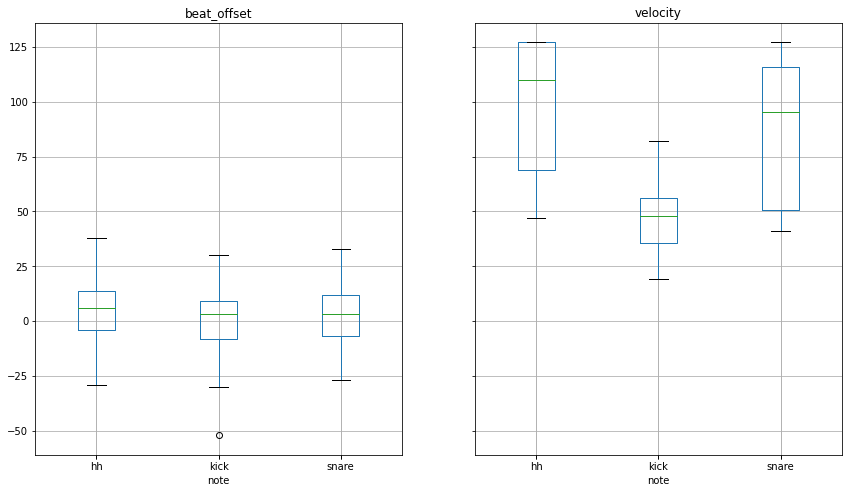

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,127.0,6.047244,13.019435,-33.0,-2.5,6.0,13.50,41.0
kick,56.0,-1.500000,13.976604,-36.0,-8.0,0.0,7.00,25.0
snare,96.0,1.510417,21.671225,-60.0,-8.0,1.0,13.25,43.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,127.0,67.614173,30.906425,13.0,41.50,57.0,91.50,127.0
kick,56.0,60.785714,10.715688,43.0,49.75,64.0,69.25,80.0
snare,96.0,80.520833,36.394036,11.0,49.50,73.5,124.75,127.0


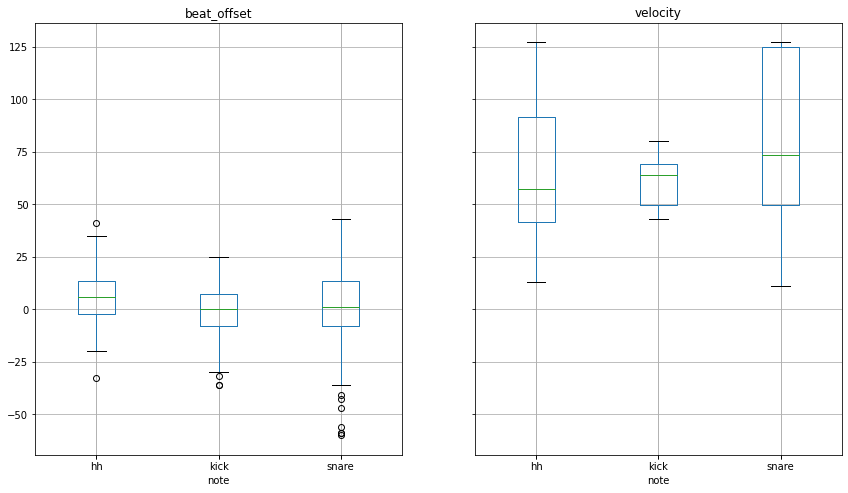

In [24]:
style_filter = "1_funk-groove1"  # first style to experiment with

for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  df_1 = perf_data.tight_df
  if style_filter in file_name:
    print('data for: {}'.format(file_name))
    df_1['beat_offset'].groupby(df_1['note']).describe()
    df_1['velocity'].groupby(df_1['note']).describe()
    _ = df_1.boxplot(by='note', column=['beat_offset', 'velocity'], figsize=(14, 8))
    #plt.title("")
    _ = plt.suptitle("")
    _ = plt.show()


## Boxplots done right, separate ones for velocity and offsets

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


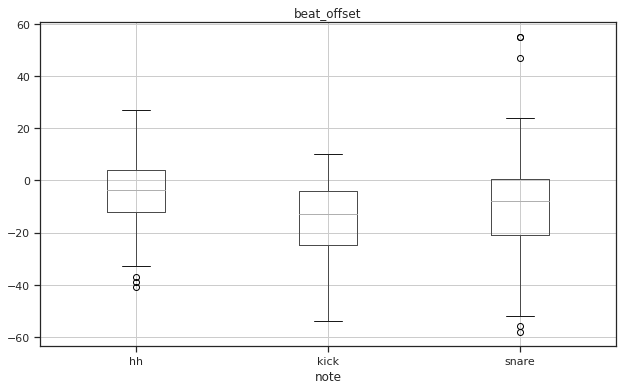

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,128.0,15.640625,15.394924,-31.0,6.0,19.0,26.00,46.0
kick,68.0,-3.985294,17.289884,-49.0,-14.0,-4.5,8.25,35.0
snare,101.0,8.663366,18.675266,-58.0,-2.0,11.0,22.00,38.0


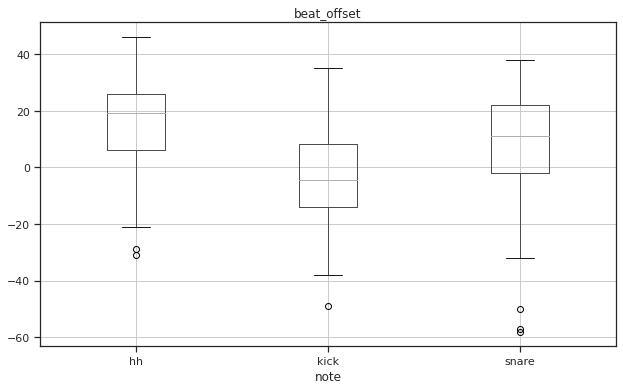

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,123.0,5.406504,13.446212,-29.0,-4.00,6.0,13.50,38.0
kick,56.0,0.375000,15.546485,-52.0,-8.25,3.0,9.25,30.0
snare,72.0,2.763889,12.853994,-27.0,-7.00,3.0,12.00,33.0


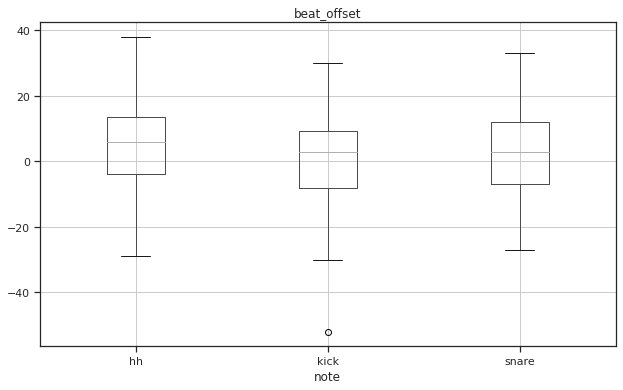

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,127.0,6.047244,13.019435,-33.0,-2.5,6.0,13.50,41.0
kick,56.0,-1.500000,13.976604,-36.0,-8.0,0.0,7.00,25.0
snare,96.0,1.510417,21.671225,-60.0,-8.0,1.0,13.25,43.0


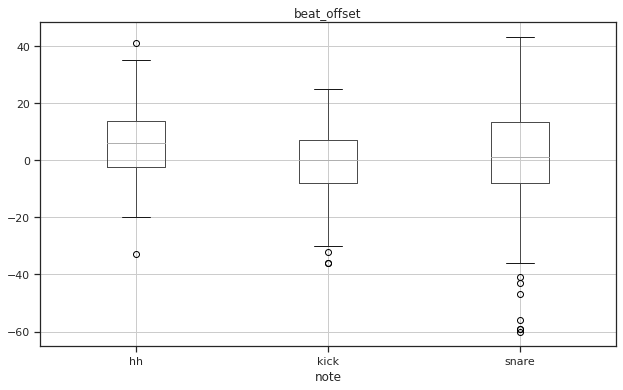

In [62]:
style_filter = "1_funk-groove1"  # first style to experiment with

for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  df_1 = perf_data.tight_df
  if style_filter in file_name:
    print('data for: {}'.format(file_name))
    df_1['beat_offset'].groupby(df_1['note']).describe()
    
    _ = df_1.boxplot(by='note', column=['beat_offset'], figsize=(10, 6))
    #plt.title("")
    _ = plt.suptitle("")
    _ = plt.show()


data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


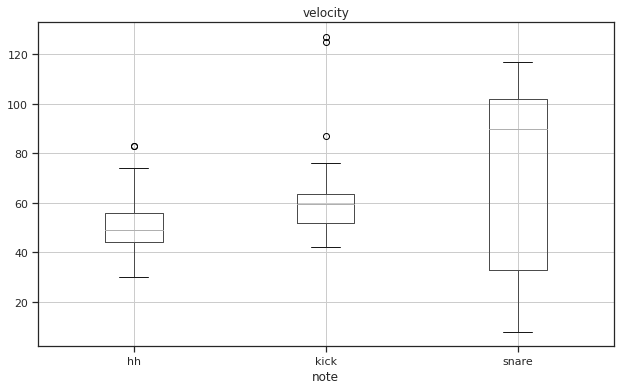

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,128.0,67.437500,25.019284,33.0,48.0,59.0,82.25,125.0
kick,68.0,31.955882,12.393347,6.0,21.0,36.0,43.00,48.0
snare,101.0,63.554455,36.469844,10.0,39.0,46.0,105.00,127.0


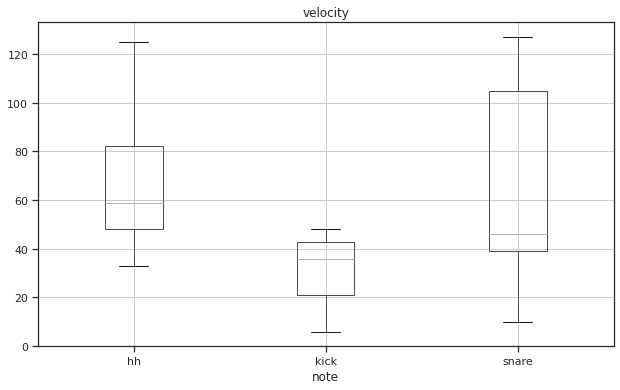

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,123.0,98.601626,29.360043,47.0,69.00,110.0,127.00,127.0
kick,56.0,47.125000,14.636272,19.0,35.75,48.0,56.25,82.0
snare,72.0,85.319444,32.378843,41.0,50.75,95.5,115.75,127.0


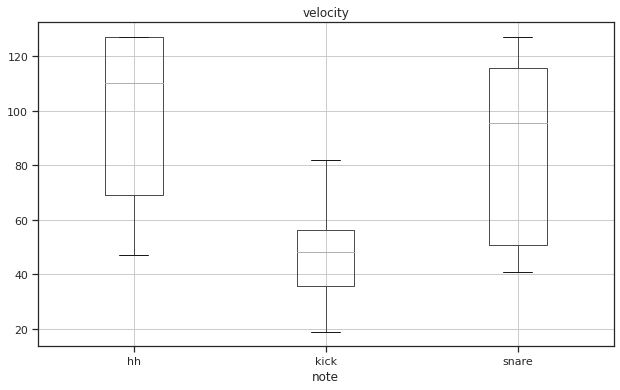

data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,127.0,67.614173,30.906425,13.0,41.50,57.0,91.50,127.0
kick,56.0,60.785714,10.715688,43.0,49.75,64.0,69.25,80.0
snare,96.0,80.520833,36.394036,11.0,49.50,73.5,124.75,127.0


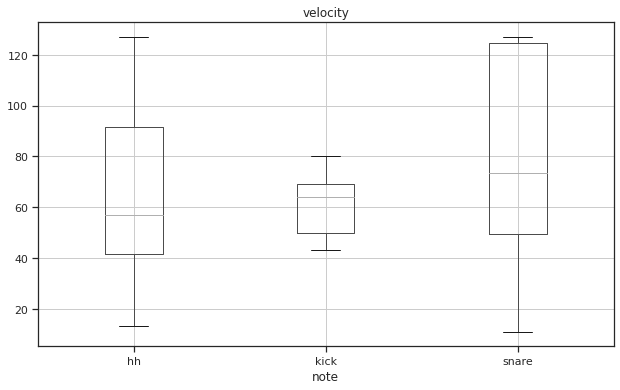

In [64]:
style_filter = "1_funk-groove1"  # first style to experiment with

for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  df_1 = perf_data.tight_df
  if style_filter in file_name:
    print('data for: {}'.format(file_name))
    df_1['velocity'].groupby(df_1['note']).describe()
    _ = df_1.boxplot(by='note', column=[ 'velocity'], figsize=(10, 6))
    #plt.title("")
    _ = plt.suptitle("")
    _ = plt.show()


# Single Song Plots

## KDF (kernel Density Function) - WRONG! split offset & velocity into diff charts!

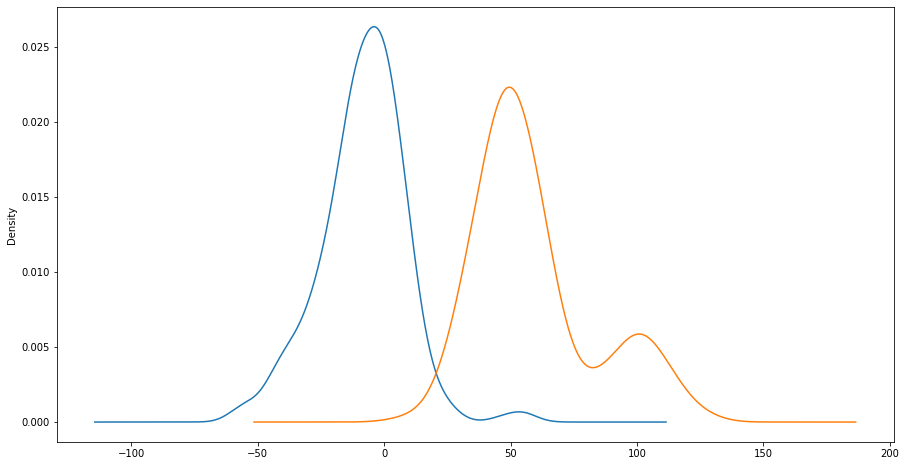

In [25]:
#df1.count()
df1.beat_offset.plot(kind='kde')
df1.velocity.plot(kind='kde', figsize=(15, 8))
#df1.plot(kind='kde', figsize=(15, 8))
#df1[df1.note == 'hh'].beat_offset.plot(kind='kde')
#df1[df1.note == 'snare'].beat_offset.plot(kind='kde')
#df1[df1.note == 'kick'].beat_offset.plot(kind='kde')

## Histograms - correct way to show univariate distributions

### Single Song, All instruments

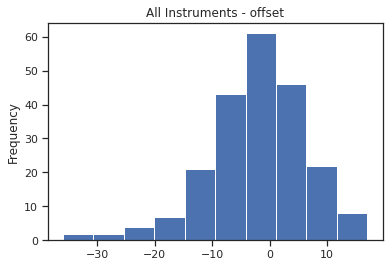

In [84]:
df1['beat_offset'].plot.hist(title='All Instruments - offset', bins=10)


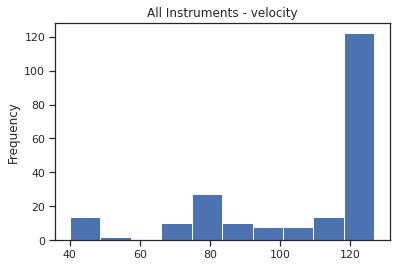

In [83]:
df1['velocity'].plot.hist(title='All Instruments - velocity', bins=10)

### Single song, separate instruments


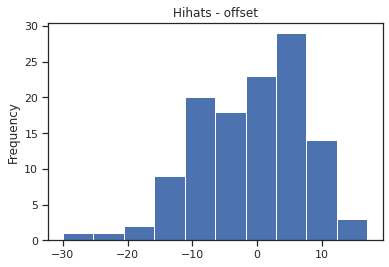

In [92]:

_ = df1['beat_offset'][df1.note == 'hh'].plot(kind='hist', title='Hihats - offset')


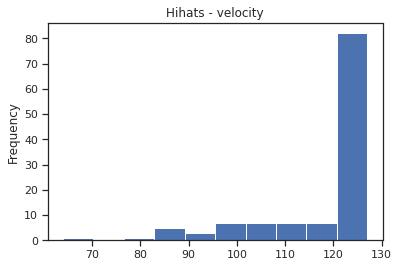

In [91]:
_ = df1['velocity'][df1.note == 'hh'].plot(kind='hist', title='Hihats - velocity')

In [ ]:
df1[df1.note == 'hh'].plot(kind='hist', x='bar_beat_number', title='Hihats')
df1[df1.note == 'snare'].plot(kind='hist', x='bar_beat_number', title='Snare Drum')
df1[df1.note == 'kick'].plot(kind='hist', x='bar_beat_number', title='Kick Drum')

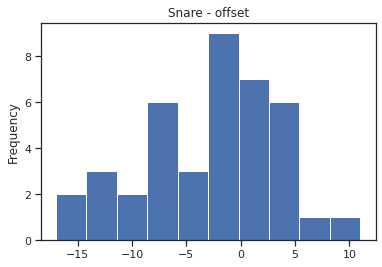

In [93]:
_ = df1['beat_offset'][df1.note == 'snare'].plot(kind='hist', title='Snare - offset')

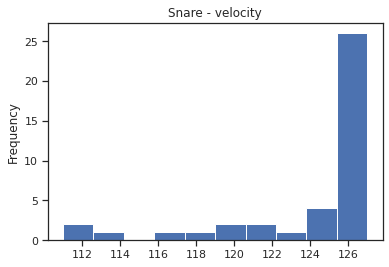

In [94]:
_ = df1['velocity'][df1.note == 'snare'].plot(kind='hist', title='Snare - velocity')

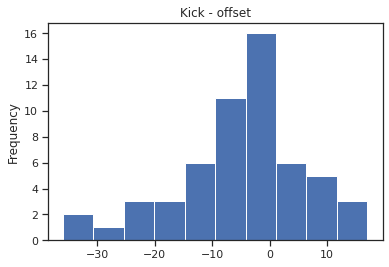

In [95]:
_ = df1['beat_offset'][df1.note == 'kick'].plot(kind='hist', title='Kick - offset')

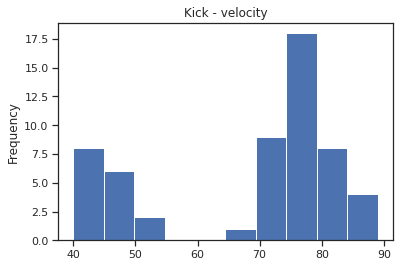

In [96]:
_ = df1['velocity'][df1.note == 'kick'].plot(kind='hist', title='Kick - velocity')

## Histograms, separate instruments - vel & offset mashup - WRONG!!!
NOTE: Eoghan confirmed this is the wrong way to do this, velocity and offset should be on *separate* charts.

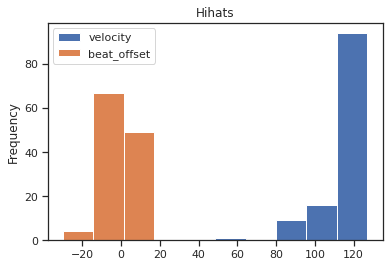

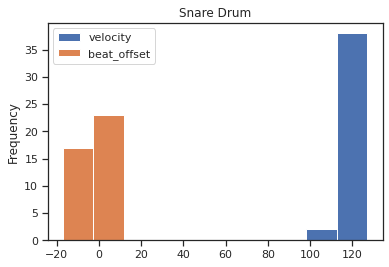

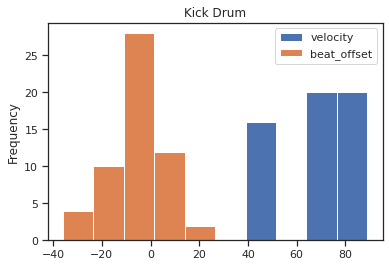

In [65]:

df1[df1.note == 'hh'].plot(kind='hist', x='bar_beat_number', title='Hihats')
df1[df1.note == 'snare'].plot(kind='hist', x='bar_beat_number', title='Snare Drum')
df1[df1.note == 'kick'].plot(kind='hist', x='bar_beat_number', title='Kick Drum')



## Av offsets, per metric pos

In [27]:
df1['beat_offset'].groupby([df1['bar_beat_number']]).describe()

,count,mean,std,min,25%,50%,75%,max
bar_beat_number,,,,,,,,
1,36.0,-9.111111,23.869619,-58.0,-23.25,-7.5,1.50,55.0
2,5.0,-21.400000,14.842507,-38.0,-35.00,-18.0,-13.00,-3.0
3,32.0,-10.812500,11.417128,-41.0,-15.25,-10.5,-1.75,11.0
4,7.0,-8.285714,8.920282,-20.0,-14.50,-8.0,-3.00,5.0
5,32.0,-4.312500,11.017398,-30.0,-8.50,-4.0,1.00,20.0
7,16.0,1.375000,12.878276,-29.0,-5.00,3.5,7.75,27.0
8,16.0,-11.687500,14.987634,-44.0,-18.00,-12.0,-0.75,10.0
9,15.0,-1.666667,14.365965,-33.0,-9.00,0.0,5.00,23.0
10,15.0,-5.600000,14.608217,-28.0,-14.50,-5.0,4.00,24.0


<Figure size 1872x720 with 0 Axes>

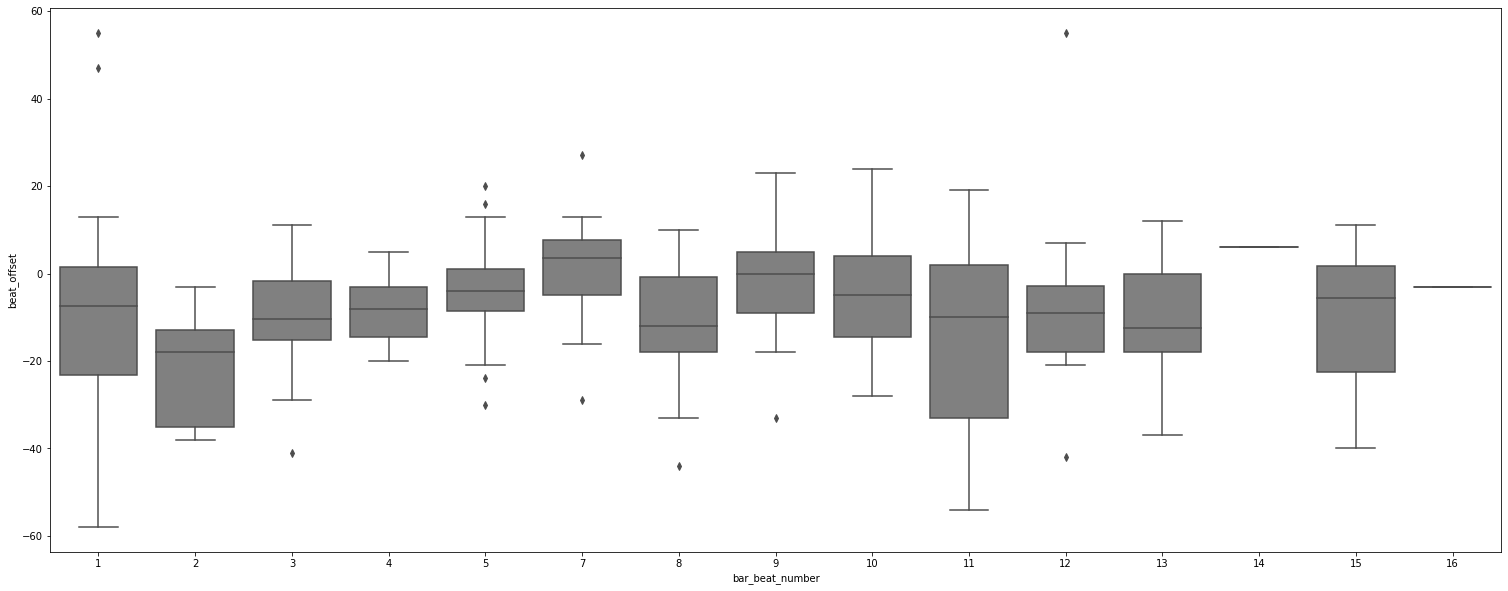

In [28]:
plt.figure(figsize=(26, 10))
sns.boxplot(y='beat_offset', x='bar_beat_number', 
            data=df1,
            color='grey') 
            #color='blue') 
            #palette="colorblind")
            #hue='note')


## Av offset, per instrument, per pos.

In [29]:
# This shows essentially the stats used to produce the boxplots below
df1['beat_offset'].groupby([df1['bar_beat_number'], df1['note']]).describe()

count       mean        std   min    25%   50%    75%  \
bar_beat_number note                                                           
1               hh      16.0  -2.937500  10.828781 -29.0  -9.50  -2.5   6.25   
                kick    12.0  -9.250000  12.144022 -25.0 -19.25  -8.0  -3.25   
                snare    8.0 -21.250000  45.937069 -58.0 -53.00 -41.0  -6.25   
2               snare    5.0 -21.400000  14.842507 -38.0 -35.00 -18.0 -13.00   
3               hh      16.0 -11.062500  12.401445 -41.0 -15.25 -11.5  -1.75   
                kick    16.0 -10.562500  10.745348 -29.0 -16.75 -10.0  -2.75   
4               hh       3.0  -8.666667   3.055050 -12.0 -10.00  -8.0  -7.00   
                kick     4.0  -8.000000  12.355835 -20.0 -17.75  -8.5   1.25   
5               hh      16.0  -3.687500  12.213210 -30.0  -6.25  -2.0   1.00   
                snare   16.0  -4.937500  10.043032 -24.0  -8.50  -6.0   0.25   
7               hh      16.0   1.375000  12.878276 -29.0  -5.00   3.5   7.75   
8               snare   16.0 -11.687500  14.987634 -44.0 -18.00 -12.0  -0.75   
9               hh      15.0  -1.666667  14.365965 -33.0  -9.00   0.0   5.00   
10              snare   15.0  -5.600000  14.608217 -28.0 -14.50  -5.0   4.00   
11              hh      12.0  -0.083333  13.255931 -32.0  -6.50   2.0   6.00   
                kick    15.0 -25.866667  18.627425 -54.0 -40.00 -26.0 -12.00   
12              kick     6.0 -17.333333  13.351654 -42.0 -20.00 -13.5  -8.50   
                snare    2.0  31.000000  33.941125   7.0  19.00  31.0  43.00   
13              hh      16.0  -9.875000  12.268523 -37.0 -18.00 -11.5   0.00   
                snare    8.0 -11.250000  10.727135 -24.0 -18.25 -15.0  -5.00   
14              kick     1.0   6.000000        NaN   6.0   6.00   6.0   6.00   
15              hh      16.0  -7.375000  14.750706 -39.0 -15.25  -5.5   6.25   
                snare    8.0 -15.750000  17.490814 -40.0 -32.00 -12.5  -1.25   
16              snare    1.0  -3.000000        NaN  -3.0  -3.00  -3.0  -3.00   

                        max  
bar_beat_number note         
1               hh     13.0  
                kick   10.0  
                snare  55.0  
2               snare  -3.0  
3               hh     11.0  
                kick    6.0  
4               hh     -6.0  
                kick    5.0  
5               hh     20.0  
                snare  16.0  
7               hh     27.0  
8               snare  10.0  
9               hh     23.0  
10              snare  24.0  
11              hh     19.0  
                kick    6.0  
12              kick   -6.0  
                snare  55.0  
13              hh     12.0  
                snare   7.0  
14              kick    6.0  
15              hh     11.0  
                snare   4.0  
16              snare  -3.0

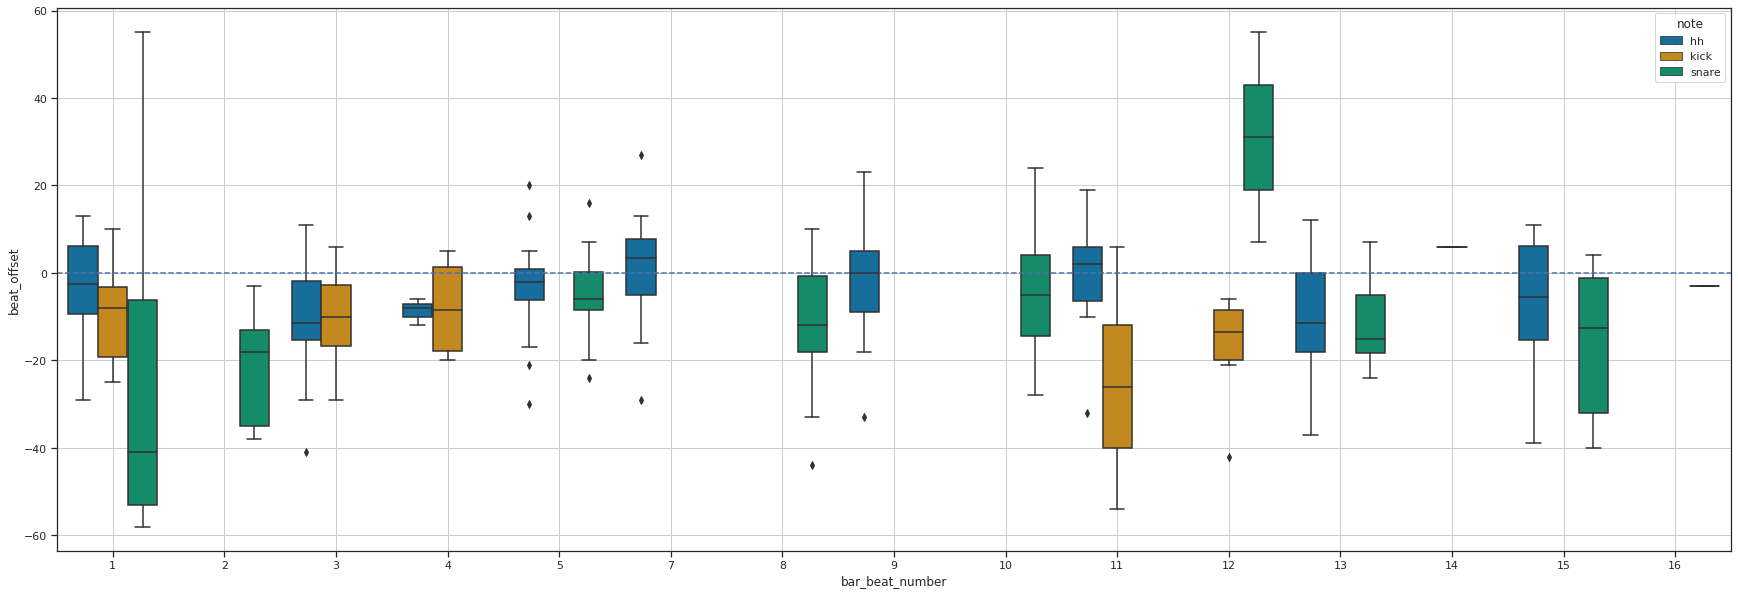

In [30]:
#plt.figure(figsize=(26, 10))
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(30, 10))

graph = sns.boxplot(y='beat_offset', x='bar_beat_number', 
                 data=df1,
                 palette="colorblind",
                 hue='note')
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)

graph.axhline(0, linestyle='--')
plt.show()

The above is clearer with added lines on x & y-axes, and the horiztonal line for '0', but doesn't give an indication of the numbers of notes.

This next version gives a better idea of the numbers of strikes/ notes per position...


<Figure size 1872x720 with 0 Axes>

<Figure size 1872x720 with 0 Axes>

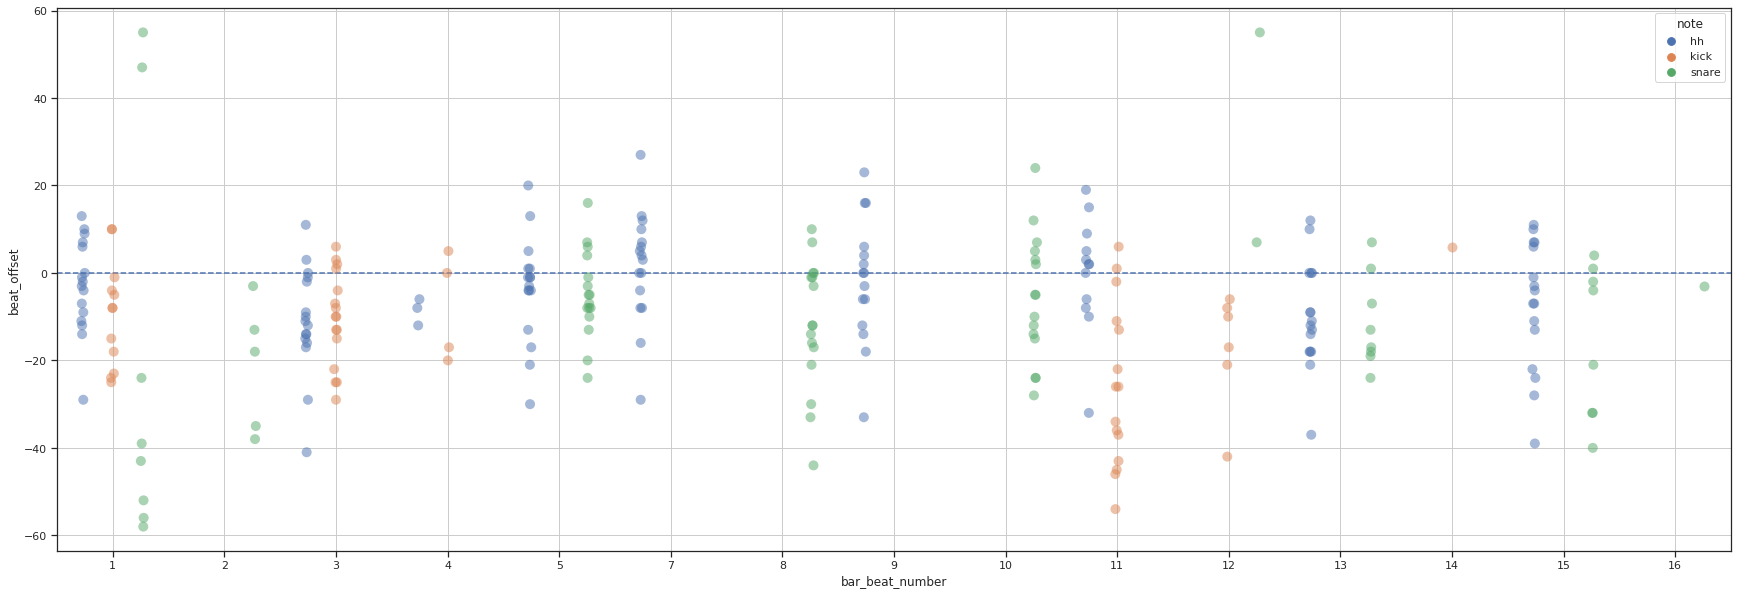

In [31]:
plt.figure(figsize=(26, 10))

f, ax = plt.subplots(figsize=(30, 10))

graph = sns.stripplot(y='beat_offset', x='bar_beat_number', 
                   data=df1, 
                   #jitter=True,
                   jitter=0.05,
                   dodge=True,
                   marker='o', 
                   alpha=0.5,
                   hue='note',
                   size=10)


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)

graph.axhline(0, linestyle='--')
plt.show()

Next version combines previous two, clear indication of median, IQR, etc. and more clearly shows numbers of strikes/ notes per position.

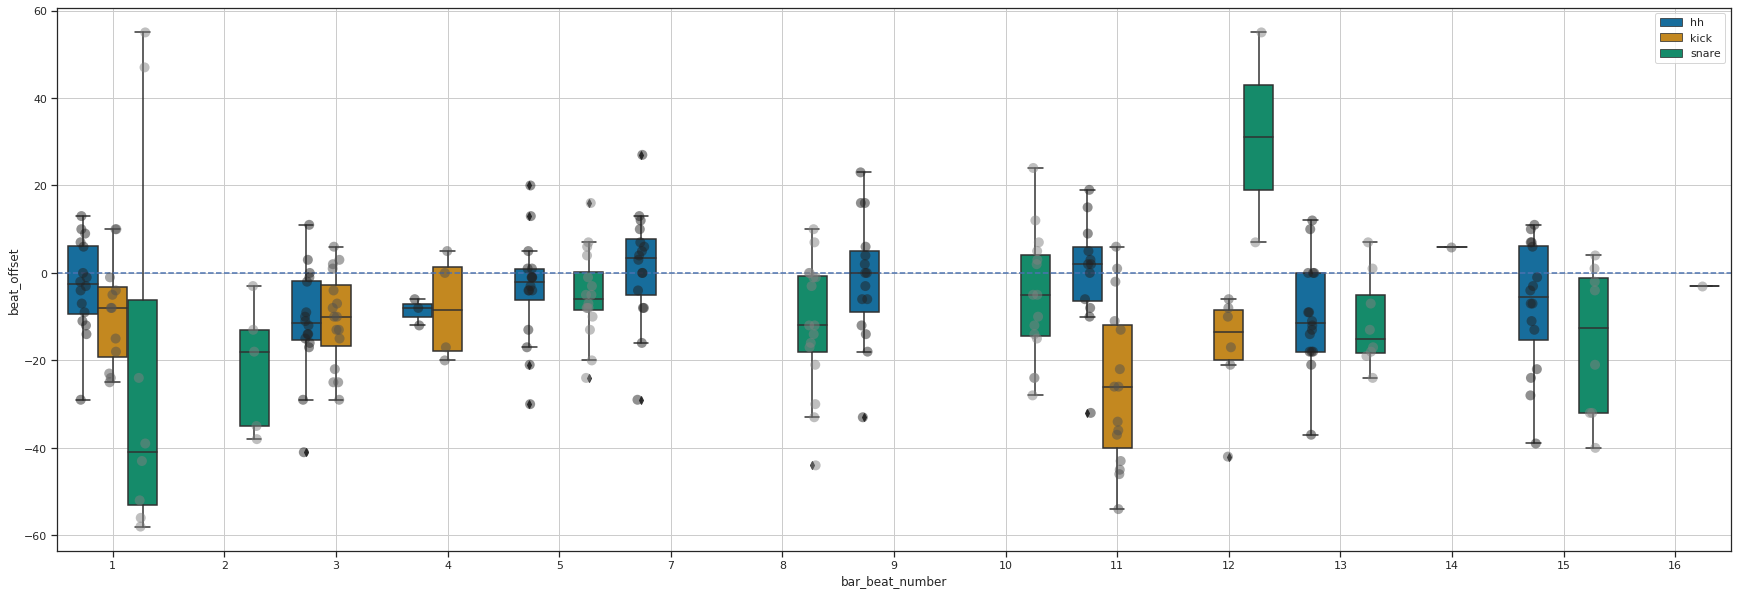

In [32]:
#plt.figure(figsize=(26, 10))
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(30, 10))


# make grouped boxplot
graph = sns.boxplot(y='beat_offset', x='bar_beat_number', 
                 data=df1, 
                 palette="colorblind", 
                  hue='note')
# make grouped stripplot
graph = sns.stripplot(y='beat_offset', x='bar_beat_number', 
                   data=df1, 
                   jitter=0.1,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='note',
                   color='grey',
                   size=10)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)

graph.axhline(0, linestyle='--')

# get legend information from the plot object
handles, labels = graph.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:3], labels[0:3])

plt.show()


## Av velocity, per pos

<Figure size 1872x720 with 0 Axes>

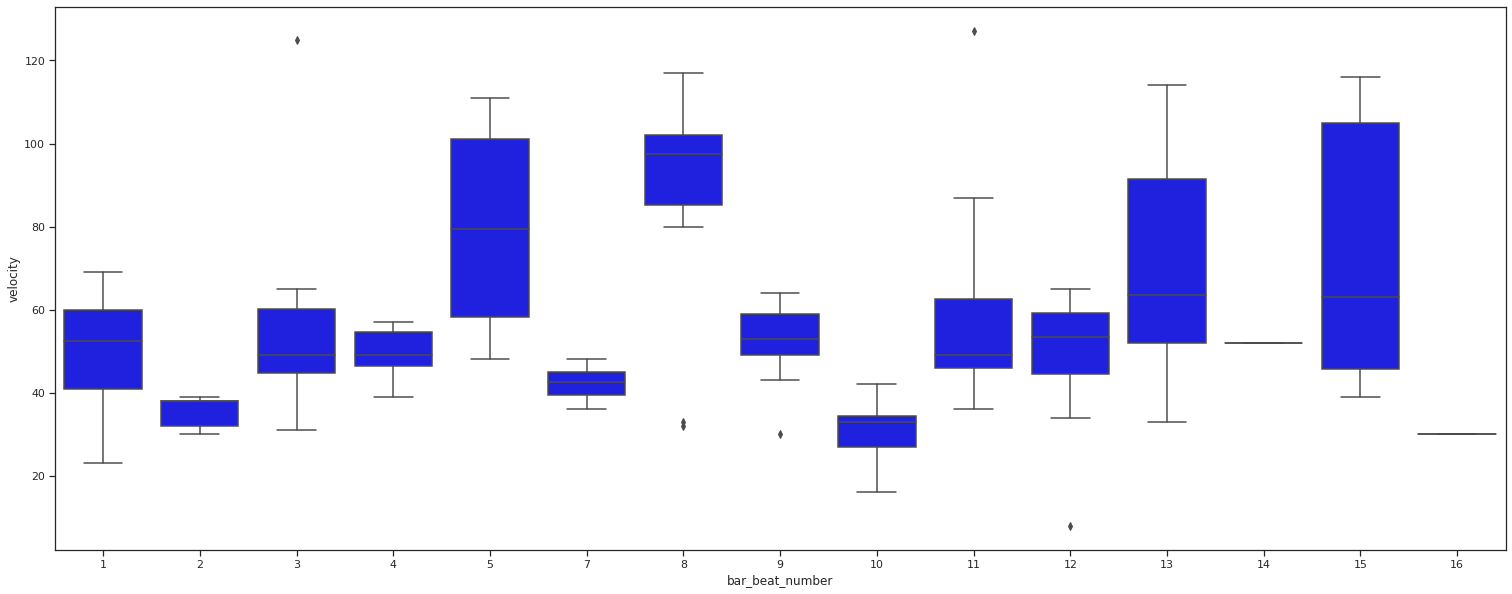

In [33]:
plt.figure(figsize=(26, 10))
sns.boxplot(y='velocity', x='bar_beat_number', 
                 data=df1, 
            color='blue') 
                 #palette="colorblind")
                 #hue='note')


<Figure size 1872x720 with 0 Axes>

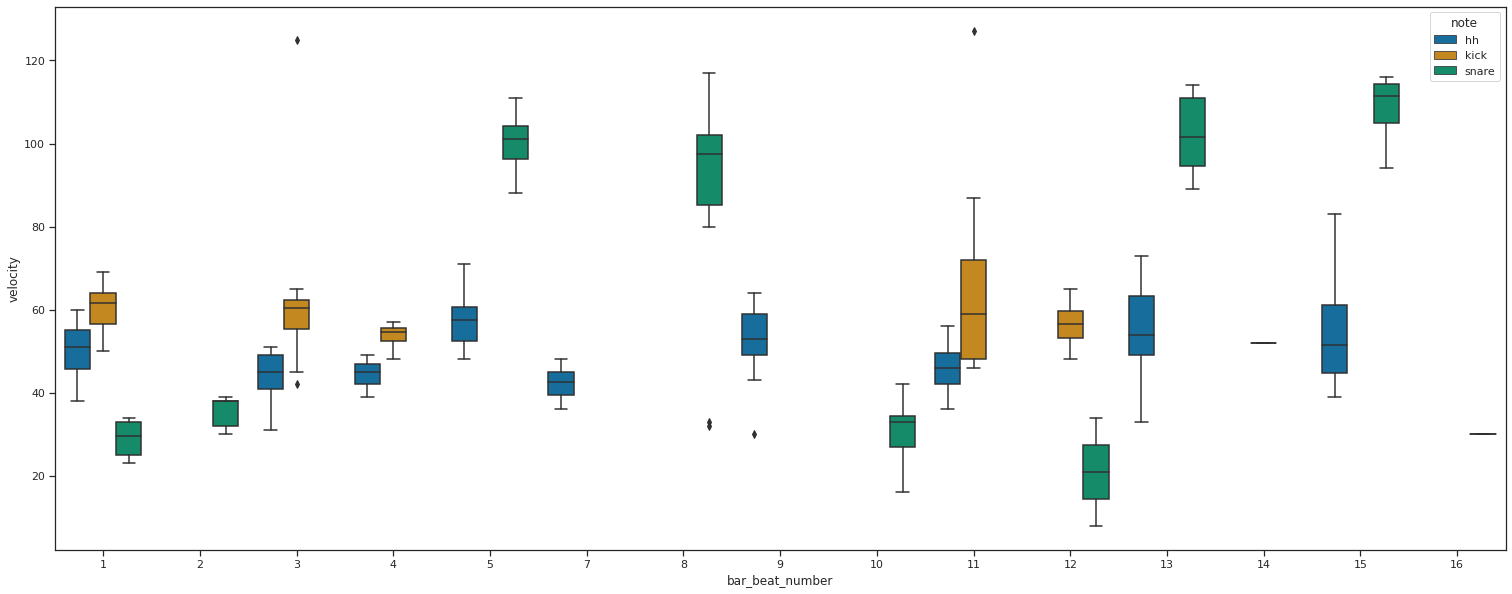

In [34]:
plt.figure(figsize=(26, 10))
sns.boxplot(y='velocity', x='bar_beat_number', 
                 data=df1, 
            # color='blue') 
                 palette="colorblind",
                 hue='note')

# Old visualisation code ::TODO::
* ::TODO:: test this out!
* not sure this is compatible any more with the data format I currently have, see how far back in the data format I need to go to produce these

In [35]:
#import visualizations as viz

# One file: one-hot, get_dummies

One-Hot, get_dummies stuff, a la..
*  https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
* https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding
* alternative, see Albon book, pg82, sklearn.preprocessing.LabelBinarizer

In [36]:
df3 = df1.copy()

# one-hot the column specifying kick/ snare/ hh
pd.get_dummies(df3.note, prefix='note', drop_first=True).head(10) 

# one-hot the column specifying metric position in the bar
pd.get_dummies(df3.bar_beat_number, prefix='beat', drop_first=True).head(10)

note_kick  note_snare
bar_number bar_beat_number                       
1          1                        0           0
           1                        1           0
           3                        1           0
           3                        0           0
           5                        0           0
           5                        0           1
           7                        0           0
           8                        0           1
           10                       0           1
           11                       1           0

beat_2  beat_3  beat_4  beat_5  beat_7  beat_8  \
bar_number bar_beat_number                                                   
1          1                     0       0       0       0       0       0   
           1                     0       0       0       0       0       0   
           3                     0       1       0       0       0       0   
           3                     0       1       0       0       0       0   
           5                     0       0       0       1       0       0   
           5                     0       0       0       1       0       0   
           7                     0       0       0       0       1       0   
           8                     0       0       0       0       0       1   
           10                    0       0       0       0       0       0   
           11                    0       0       0       0       0       0   

                            beat_9  beat_10  beat_11  beat_12  beat_13  \
bar_number bar_beat_number                                               
1          1                     0        0        0        0        0   
           1                     0        0        0        0        0   
           3                     0        0        0        0        0   
           3                     0        0        0        0        0   
           5                     0        0        0        0        0   
           5                     0        0        0        0        0   
           7                     0        0        0        0        0   
           8                     0        0        0        0        0   
           10                    0        1        0        0        0   
           11                    0        0        1        0        0   

                            beat_14  beat_15  beat_16  
bar_number bar_beat_number                             
1          1                      0        0        0  
           1                      0        0        0  
           3                      0        0        0  
           3                      0        0        0  
           5                      0        0        0  
           5                      0        0        0  
           7                      0        0        0  
           8                      0        0        0  
           10                     0        0        0  
           11                     0        0        0

- Now do it for real, append the new one-hot cols
- (optional) remove the cols that made them...

In [37]:
df4 = df3.copy()

# join the new columns with  original dataframe
df4 = pd.concat([df4,pd.get_dummies(df4.note, prefix='note', drop_first=True)],axis=1)
#df4.drop('note',axis=1, inplace=True)  # drop original 'note' col

df4 = pd.concat([df4,pd.get_dummies(df4.bar_beat_number, prefix='beat', drop_first=True)],axis=1)
#df4.drop('bar_beat_number',axis=1, inplace=True)  # drop original 'note' col

df4.head(25)

note  velocity  beat_offset  bar_beat_number  \
bar_number bar_beat_number                                                  
1          1                   hh        55            7                1   
           1                 kick        64           10                1   
           3                 kick        57          -29                3   
           3                   hh        31           -2                3   
           5                   hh        54          -13                5   
           5                snare        93           -5                5   
           7                   hh        42          -16                7   
           8                snare        33          -12                8   
           10               snare        33          -14               10   
           11                kick        59          -37               11   
           11                  hh        42          -32               11   
           13                  hh        64          -18               13   
           13               snare       114            7               13   
           15                  hh        44           -1               15   
           16               snare        30           -3               16   
2          1                   hh        42           -7                1   
           1                 kick        55           -5                1   
           3                 kick        62          -10                3   
           3                   hh        41            3                3   
           5                snare        94            4                5   
           5                   hh        51            5                5   
           7                   hh        45            7                7   
           8                snare        32            7                8   
           9                   hh        43            2                9   
           10               snare        24           -5               10   

                            note_kick  note_snare  beat_2  beat_3  beat_4  \
bar_number bar_beat_number                                                  
1          1                        0           0       0       0       0   
           1                        1           0       0       0       0   
           3                        1           0       0       1       0   
           3                        0           0       0       1       0   
           5                        0           0       0       0       0   
           5                        0           1       0       0       0   
           7                        0           0       0       0       0   
           8                        0           1       0       0       0   
           10                       0           1       0       0       0   
           11                       1           0       0       0       0   
           11                       0           0       0       0       0   
           13                       0           0       0       0       0   
           13                       0           1       0       0       0   
           15                       0           0       0       0       0   
           16                       0           1       0       0       0   
2          1                        0           0       0       0       0   
           1                        1           0       0       0       0   
           3                        1           0       0       1       0   
           3                        0           0       0       1       0   
           5                        0           1       0       0       0   
           5                        0           0       0       0       0   
           7                        0           0       0       0       0   
           8                        0           1       0       0       0   
           9            

# One file: compare MinMax & Robust Scalers (normalization)


References, comments, thoughts...
* Many algorithms need data rescaled and perform better with it, some behave fine with unscaled data e.g. decision trees, random forests.
* [Scaling from scratch](https://machinelearningmastery.com/scale-machine-learning-data-scratch-python/)
* [Robust Scalar](https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/) :  value = (value – median) / (p75 – p25)
* https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
* https://stats.stackexchange.com/questions/77350/perform-feature-normalization-before-or-within-model-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
* ["Not only do you need normalisation, but you should apply the exact same scaling as for your training data. That means storing the scale and offset used with your training data, and using that again. A common beginner mistake is to separately normalise your train and test data."](https://datascience.stackexchange.com/a/27616)


In summary...
* Normalize - don't know distribution, or know it's not guassian, algorithm doesn't make assumptions about distribution

* Standardization - assumes data is Guassian/ bell shaped, and when algorithms assumes Guassian.

* Robust scalar - Scales features using statistics that are robust to outliers, uses median and quantiles, consists of subtracting the median from an observation and then dividing by the interquartile difference. Distributions are not centered in zero and the standard deviation is not 1. Min & max values set to a certain upper and lower boundaries like in the MinMaxScaler.

* BUT - the Groove MIDI paper explicitly states, it scales offsets to between -0.5 and +0.5, and velocity to between 0 and 1.

Final step to prep data for KNN, I need to do some scaling of the columns: 'velocity', 'beat_offset' ..



```
For KNN, data needs to be in format ..
- Observation X = Class Y

Suggested data format
- X = [instrument, metric position, offset, velocity]
- Y = best guess at which drummer it is.

Details..
- instrument = kick, snare, hh/ ride (categorical, order not important = nominal categorical)
- metric position = 1 to 16  (numeric, order not important = nominal categorical)
- offset = -60 to +60  (offset range is # ticks per beat, +/- half of that)
- velocity = 0 to 127 (MIDI volume range is 1 to 127)
```




More thoughts on normalization and clustering..

From: https://jamesmccaffrey.wordpress.com/2020/08/10/data-prep-for-machine-learning-normalization/

> "For numeric data clustering algorithms, such as k-means variants, clustering is usually essential. These clustering algorithms are based on a distance metric. If data is not normalized, variables with large magnitudes (such as annual income) will dominate variables with smaller magnitudes (such as age). Without normalization the clustering will be effectively based on just the variable which has values with the largest magnitudes."




In [38]:
# Experimenting with manual normalisation...
x = [1, 2, 3, 4]

def normalize(x):
    maxx, minx = max(x), min(x)
    max_minus_min = maxx - minx
    return [(elt - minx) / max_minus_min for elt in x]

print(normalize(x))


[0.0, 0.3333333333333333, 0.6666666666666666, 1.0]


In [39]:
# take a look at what we have so far...
df4.describe()

,velocity,beat_offset,bar_beat_number,note_kick,note_snare,beat_2,beat_3,beat_4,beat_5,beat_7,beat_8,beat_9,beat_10,beat_11,beat_12,beat_13,beat_14,beat_15,beat_16
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,59.023166,-8.382239,7.528958,0.208494,0.305019,0.019305,0.123552,0.027027,0.123552,0.061776,0.061776,0.057915,0.057915,0.104247,0.030888,0.092664,0.003861,0.092664,0.003861
std,23.861508,16.705284,4.585338,0.407018,0.461307,0.137861,0.329707,0.162476,0.329707,0.241214,0.241214,0.234035,0.234035,0.306172,0.173349,0.290523,0.062137,0.290523,0.062137
min,8.000000,-58.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,-17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,-7.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,65.500000,1.500000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,127.000000,55.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

Get dataframe column/ series into the right shape for use in the following...
* https://stackoverflow.com/a/40698011

In [41]:
##############################
# velocity
##############################


data = df4.velocity
x = data.values.reshape(-1, 1) #returns a numpy array

# min/max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)
df4['velocity_scaled'] = x_scaled

# robust scaling
x_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(x)
df4['velocity_scaled_r'] = x_scaled


################################
# offset
################################



data = df4.beat_offset
x = data.values.reshape(-1, 1) #returns a numpy array

# min/max scaling
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
x_scaled = scaler.fit_transform(x)
df4['offset_scaled'] = x_scaled

# robust
x_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(x)
df4['offset_scaled_r'] = x_scaled

# compare MinMaxScaler & RobustScaler stats..
df4.filter(items=['velocity_scaled', 'velocity_scaled_r', 'offset_scaled', 'offset_scaled_r']).describe()
df4.head(20)


,velocity_scaled,velocity_scaled_r,offset_scaled,offset_scaled_r
count,259.000000,259.000000,259.000000,259.000000
mean,0.428766,0.326659,-0.060905,-0.074716
std,0.200517,1.109838,0.147834,0.902988
min,0.000000,-2.046512,-0.500000,-2.756757
25%,0.302521,-0.372093,-0.137168,-0.540541
50%,0.369748,0.000000,-0.048673,0.000000
75%,0.483193,0.627907,0.026549,0.459459
max,1.000000,3.488372,0.500000,3.351351


note  velocity  beat_offset  bar_beat_number  \
bar_number bar_beat_number                                                  
1          1                   hh        55            7                1   
           1                 kick        64           10                1   
           3                 kick        57          -29                3   
           3                   hh        31           -2                3   
           5                   hh        54          -13                5   
           5                snare        93           -5                5   
           7                   hh        42          -16                7   
           8                snare        33          -12                8   
           10               snare        33          -14               10   
           11                kick        59          -37               11   
           11                  hh        42          -32               11   
           13                  hh        64          -18               13   
           13               snare       114            7               13   
           15                  hh        44           -1               15   
           16               snare        30           -3               16   
2          1                   hh        42           -7                1   
           1                 kick        55           -5                1   
           3                 kick        62          -10                3   
           3                   hh        41            3                3   
           5                snare        94            4                5   

                            note_kick  note_snare  beat_2  beat_3  beat_4  \
bar_number bar_beat_number                                                  
1          1                        0           0       0       0       0   
           1                        1           0       0       0       0   
           3                        1           0       0       1       0   
           3                        0           0       0       1       0   
           5                        0           0       0       0       0   
           5                        0           1       0       0       0   
           7                        0           0       0       0       0   
           8                        0           1       0       0       0   
           10                       0           1       0       0       0   
           11                       1           0       0       0       0   
           11                       0           0       0       0       0   
           13                       0           0       0       0       0   
           13                       0           1       0       0       0   
           15                       0           0       0       0       0   
           16                       0           1       0       0       0   
2          1                        0           0       0       0       0   
           1                        1           0       0       0       0   
           3                        1           0       0       1       0   
           3                        0           0       0       1       0   
           5                        0           1       0       0       0   

                            beat_5  beat_7  beat_8  beat_9  beat_10  beat_11  \
bar_number bar_beat_number                                                     
1          1                     0       0       0       0        0        0   
           1                     0       0       0       0        0        0   
           3                     0       0       0       0        0        0   
           3                     0       0       0       0        0        0   
           5                     1       0       0       0        0        0   
           5                     1       0       0       0        0        0   

## Variance metrics

In [42]:

print('variance stats for: {}'.format(key1))
print('  vel: {}'.format(statistics.variance(df4.velocity_scaled)))
print('  vel_r: {}'.format(statistics.variance(df4.velocity_scaled_r)))


#print('variance stats for: {}'.format(key2))
print('  off: {}'.format(statistics.variance(df4.offset_scaled)))
print('  off_r: {}'.format(statistics.variance(df4.offset_scaled_r)))

variance stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
  vel: 0.040207016049610265
  vel_r: 1.2317394359730256
  off: 0.021855000786533733
  off_r: 0.8153878890964185


**NOTE: the above behaves unexpectedly, i.e. there are offset notes at 0 (zero) in the data, but the scaled number is *not* zero.**

## 3-4D plots
Experimenting with other plots...
* https://seaborn.pydata.org/tutorial/relational.html#relating-variables-with-scatter-plots

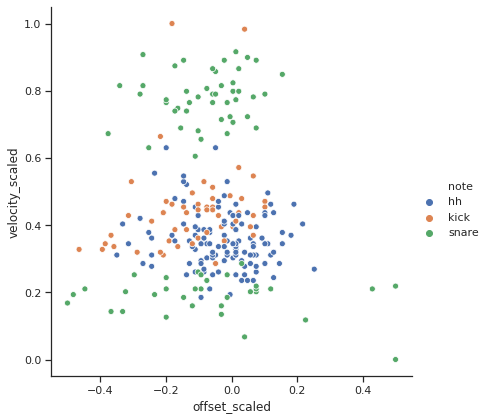

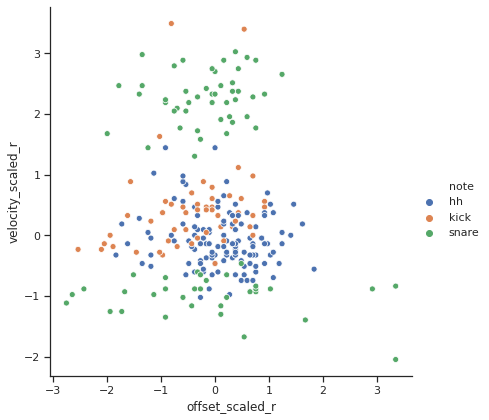

In [43]:

sns.relplot(x="offset_scaled", y="velocity_scaled", hue="note", data=df4, height=6)
sns.relplot(x="offset_scaled_r", y="velocity_scaled_r", hue="note", data=df4, height=6)
#sns.relplot(x="offset_scaled", y="velocity_scaled", hue="bar_beat_number", style="note", data=df4, height=8)

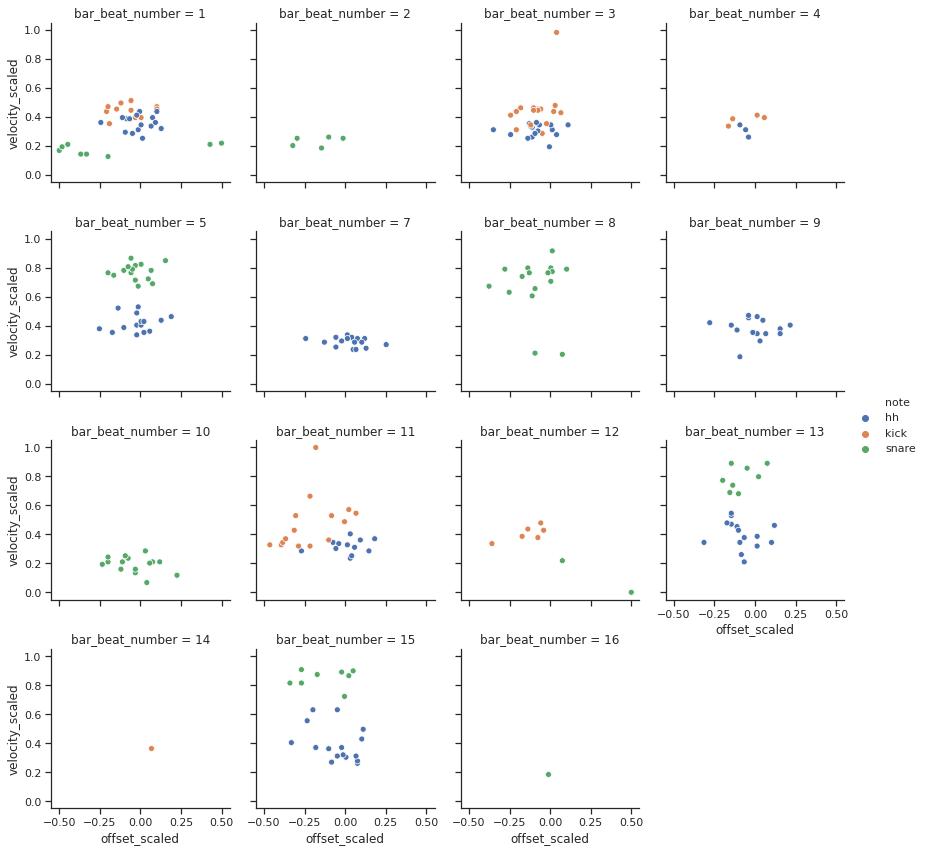

In [44]:

# sns.relplot(x="offset_scaled", y="velocity_scaled", hue="note", col="bar_beat_number", col_wrap=4, data=df4, height=2)

sns.relplot(x="offset_scaled", y="velocity_scaled", hue="note", col="bar_beat_number", col_wrap=4, data=df4, height=3)


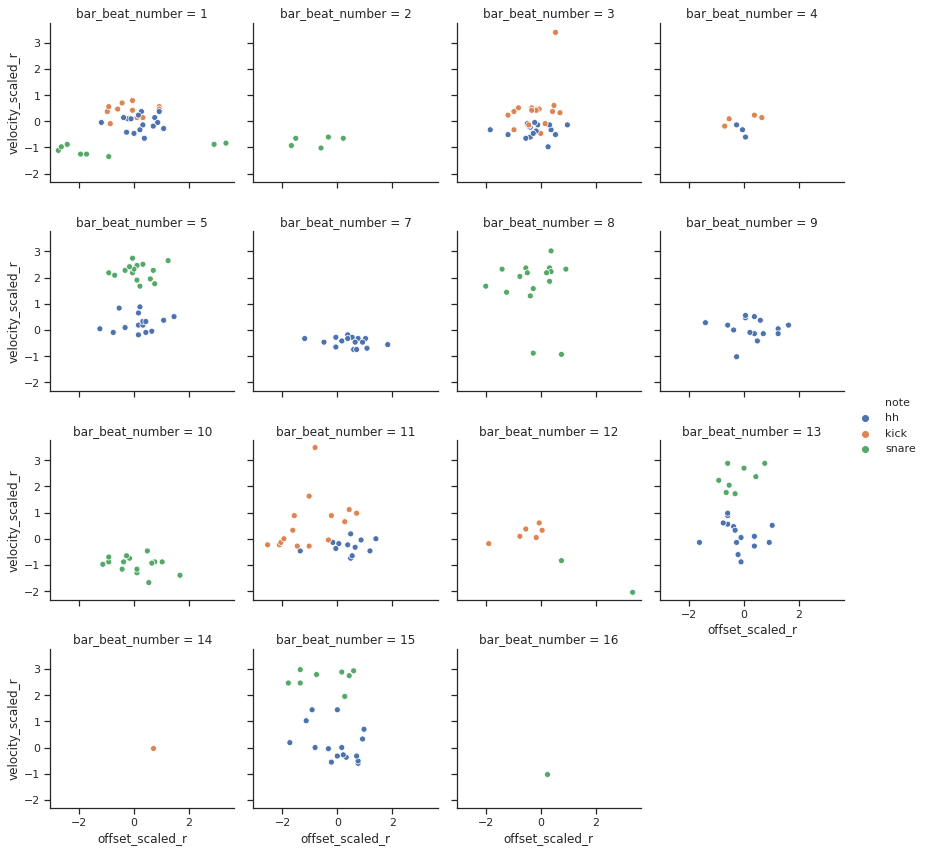

In [45]:
sns.relplot(x="offset_scaled_r", y="velocity_scaled_r", hue="note", col="bar_beat_number", col_wrap=4, data=df4, height=3)

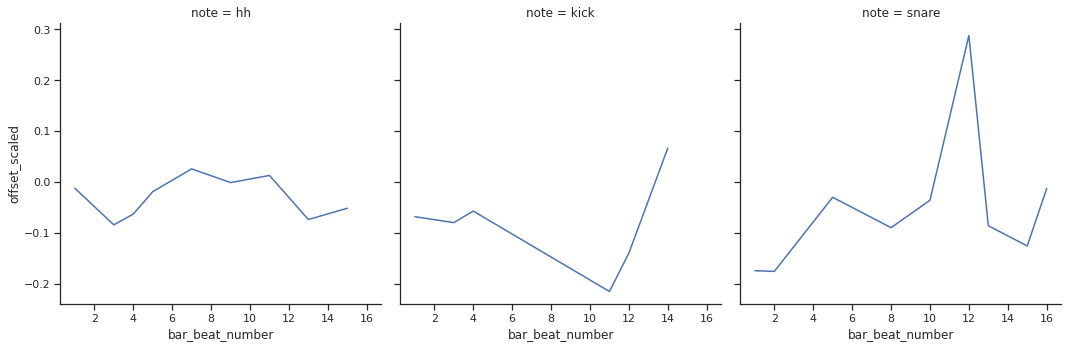

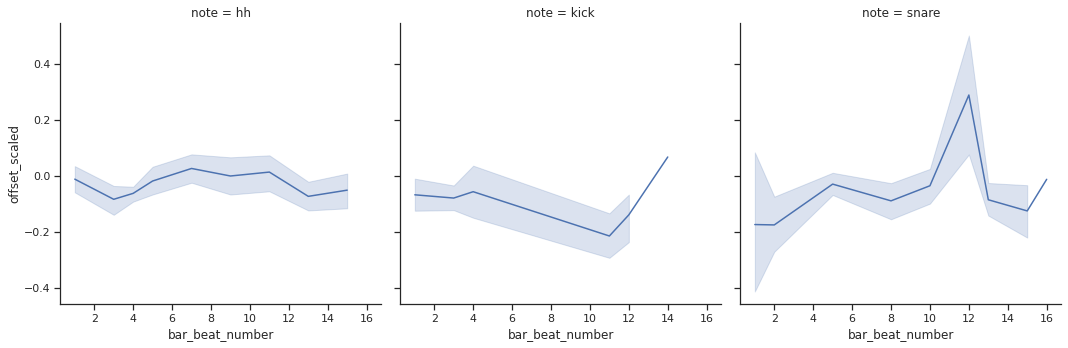

In [46]:
sns.relplot(x="bar_beat_number", y="offset_scaled", col="note", col_wrap=3, data=df4, height=5, kind="line", ci=None)
sns.relplot(x="bar_beat_number", y="offset_scaled", col="note", col_wrap=3, data=df4, height=5, kind="line")
#sns.relplot(x="bar_beat_number", y="offset_scaled", hue="note", data=df4, height=10, kind="line")



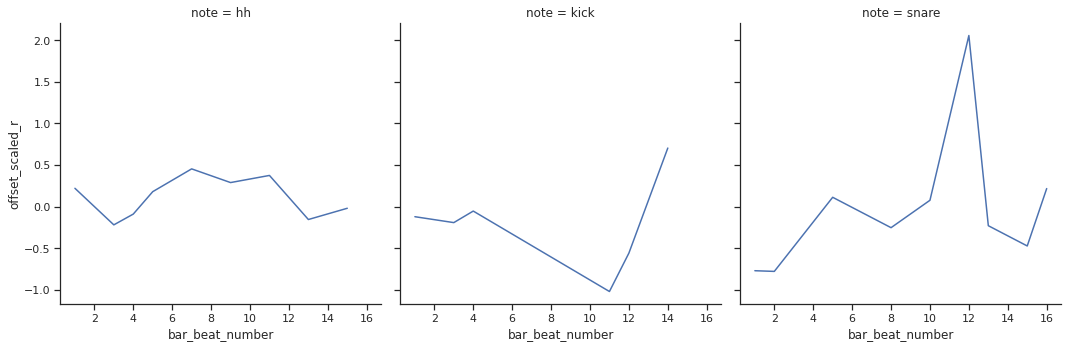

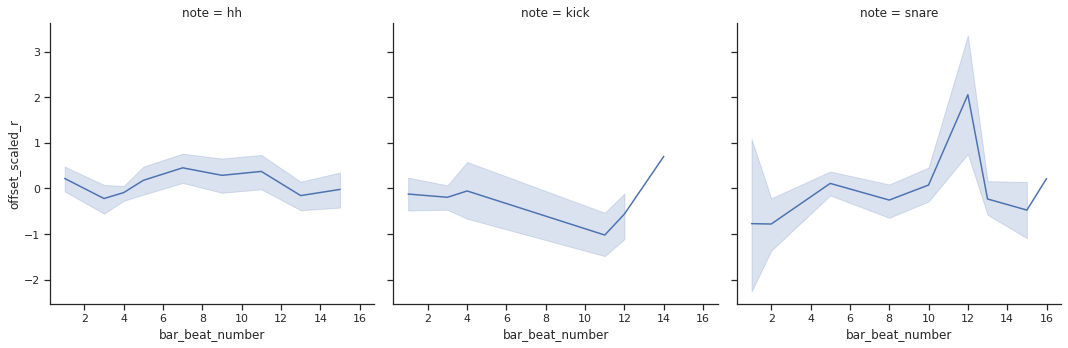

In [47]:
sns.relplot(x="bar_beat_number", y="offset_scaled_r", col="note", col_wrap=3, data=df4, height=5, kind="line", ci=None)
sns.relplot(x="bar_beat_number", y="offset_scaled_r", col="note", col_wrap=3, data=df4, height=5, kind="line")
#sns.relplot(x="bar_beat_number", y="offset_scaled", hue="note", data=df4, height=10, kind="line")

# Util methods for GetDummies, OneHot, adding label, etc.

In [48]:

def getDummies(df):
  '''
  Takes as input data_prep.PerformanceData.tight_df

  Returns df with additional colums for getDummies/ 1-hot encoding of instrument & note
  getDummies/ 1-hot encoding of instrument & note position (bucket)
  '''
  tmp_df = df.copy()

  #### get dummies/ one-hot

  # join the new columns with  original dataframe
  tmp_df = pd.concat([tmp_df,pd.get_dummies(tmp_df.note, prefix='note', drop_first=True)],axis=1)
  #tmp_df.drop('note',axis=1, inplace=True)  # drop original 'note' col

  tmp_df = pd.concat([tmp_df,pd.get_dummies(tmp_df.bar_beat_number, prefix='beat', drop_first=True)],axis=1)
  #tmp_df.drop('bar_beat_number',axis=1, inplace=True)  # drop original 'bar_beat_number' col

  return tmp_df


def getScaling(df):
  '''
  Takes as input data_prep.PerformanceData.tight_df

  Returns df with additional colums for MinMax/Robust cols for velocity & offset
  '''

  tmp_df = df.copy()

  #### Velocity Scaling

  data = tmp_df.velocity
  x = data.values.reshape(-1, 1) #returns a numpy array

  # min/max scaling
  scaler = MinMaxScaler(feature_range=(0, 1))
  x_scaled = scaler.fit_transform(x)
  tmp_df['velocity_scaled'] = x_scaled

  # robust scaling
  x_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(x)
  tmp_df['velocity_scaled_r'] = x_scaled


  #### Offset Scaling

  data = tmp_df.beat_offset
  x = data.values.reshape(-1, 1) #returns a numpy array

  # min/max scaling
  scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
  x_scaled = scaler.fit_transform(x)
  tmp_df['offset_scaled'] = x_scaled

  # robust
  x_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(x)
  tmp_df['offset_scaled_r'] = x_scaled

  # DEBUG compare MinMaxScaler & RobustScaler stats..
  #df.filter(items=['velocity_scaled', 'velocity_scaled_r', 'offset_scaled', 'offset_scaled_r']).describe()
  #df.head(20)

  return tmp_df


def addLabelCol(df, label):
  '''
  Takes as input data_prep.PerformanceData.tight_df

  Returns df with additional colum for Y/ label called 'drummer_ID'
  '''

  # df['drummer_ID'] = label
  df.insert(0, 'drummer_ID', label) # add it as first col

  return df



# Test util methods

In [49]:
df1.head()

note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

In [50]:
tmp_df_1 = getDummies(df1)
tmp_df_2 = getScaling(tmp_df_1)
tmp_df_3 = addLabelCol(tmp_df_2, 'plop')

tmp_df_3.head()

# drop velocity,beat_offset,bar_beat_number, note
tmp_df_3.drop(['velocity','beat_offset','bar_beat_number', 'note'],axis=1, inplace=True)

tmp_df_3.head()

drummer_ID  note  velocity  beat_offset  \
bar_number bar_beat_number                                           
1          1                     plop    hh        55            7   
           1                     plop  kick        64           10   
           3                     plop  kick        57          -29   
           3                     plop    hh        31           -2   
           5                     plop    hh        54          -13   

                            bar_beat_number  note_kick  note_snare  beat_2  \
bar_number bar_beat_number                                                   
1          1                              1          0           0       0   
           1                              1          1           0       0   
           3                              3          1           0       0   
           3                              3          0           0       0   
           5                              5          0           0       0   

                            beat_3  beat_4  beat_5  beat_7  beat_8  beat_9  \
bar_number bar_beat_number                                                   
1          1                     0       0       0       0       0       0   
           1                     0       0       0       0       0       0   
           3                     1       0       0       0       0       0   
           3                     1       0       0       0       0       0   
           5                     0       0       1       0       0       0   

                            beat_10  beat_11  beat_12  beat_13  beat_14  \
bar_number bar_beat_number                                                
1          1                      0        0        0        0        0   
           1                      0        0        0        0        0   
           3                      0        0        0        0        0   
           3                      0        0        0        0        0   
           5                      0        0        0        0        0   

                            beat_15  beat_16  velocity_scaled  \
bar_number bar_beat_number                                      
1          1                      0        0         0.394958   
           1                      0        0         0.470588   
           3                      0        0         0.411765   
           3                      0        0         0.193277   
           5                      0        0         0.386555   

                            velocity_scaled_r  offset_scaled  offset_scaled_r  
bar_number bar_beat_number                                                     
1          1                         0.139535       0.075221         0.756757  
           1                         0.558140       0.101770         0.918919  
           3                         0.232558      -0.243363        -1.189189  
           3                        -0.976744      -0.004425         0.270270  
           5                         0.093023      -0.101770        -0.324324

drummer_ID  note_kick  note_snare  beat_2  beat_3  \
bar_number bar_beat_number                                                     
1          1                     plop          0           0       0       0   
           1                     plop          1           0       0       0   
           3                     plop          1           0       0       1   
           3                     plop          0           0       0       1   
           5                     plop          0           0       0       0   

                            beat_4  beat_5  beat_7  beat_8  beat_9  beat_10  \
bar_number bar_beat_number                                                    
1          1                     0       0       0       0       0        0   
           1                     0       0       0       0       0        0   
           3                     0       0       0       0       0        0   
           3                     0       0       0       0       0        0   
           5                     0       1       0       0       0        0   

                            beat_11  beat_12  beat_13  beat_14  beat_15  \
bar_number bar_beat_number                                                
1          1                      0        0        0        0        0   
           1                      0        0        0        0        0   
           3                      0        0        0        0        0   
           3                      0        0        0        0        0   
           5                      0        0        0        0        0   

                            beat_16  velocity_scaled  velocity_scaled_r  \
bar_number bar_beat_number                                                
1          1                      0         0.394958           0.139535   
           1                      0         0.470588           0.558140   
           3                      0         0.411765           0.232558   
           3                      0         0.193277          -0.976744   
           5                      0         0.386555           0.093023   

                            offset_scaled  offset_scaled_r  
bar_number bar_beat_number                                  
1          1                     0.075221         0.756757  
           1                     0.101770         0.918919  
           3                    -0.243363        -1.189189  
           3                    -0.004425         0.270270  
           5                    -0.101770        -0.324324

.. looking good!


# Add  req'd features, merge dfs into one



In [51]:
# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
style_filter = "8_rock-groove8"

songs_data = []


# iterate and process
for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  if style_filter in file_name:
    print('Working on: {}'.format(file_name))
    df1 = perf_data.tight_df.copy()
    df2 = addLabelCol(df1, perf_data.drummer_id)  
    df2.reset_index(drop=True, inplace=True)
    songs_data.append(df2)
  else:
    print('ignoring: {}'.format(file_name))



ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid
Working on: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid
ignoring: /content/drive/My Drive/groove-v1.0.0-midionly/g

In [52]:
all_data = pd.concat(songs_data)
all_data.reset_index(inplace=True, drop=True)

tmp_df_1 = getDummies(all_data)
tmp_df_2 = getScaling(tmp_df_1)
tmp_df_2.drop(['velocity','beat_offset','bar_beat_number', 'note'],axis=1, inplace=True)
data = tmp_df_2
data.head(25)
data.tail(25)


,drummer_ID,note_kick,note_snare,beat_3,beat_5,beat_6,beat_7,beat_8,beat_9,beat_11,beat_12,beat_13,beat_14,beat_15,beat_16,velocity_scaled,velocity_scaled_r,offset_scaled,offset_scaled_r
0,drummer1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.909091,0.474576,0.166667,0.400000
1,drummer1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.793388,0.237288,0.166667,0.400000
2,drummer1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.603306,-0.152542,0.206667,0.600000
3,drummer1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.925620,0.508475,0.166667,0.400000
4,drummer1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.735537,0.118644,0.206667,0.600000
5,drummer1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.644628,-0.067797,0.126667,0.200000
6,drummer1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.413223,-0.542373,-0.020000,-0.533333
7,drummer1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.752066,0.152542,0.006667,-0.400000
8,drummer1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.578512,-0.203390,0.086667,0.000000
9,drummer1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.867769,0.389831,0.020000,-0.333333


,drummer_ID,note_kick,note_snare,beat_3,beat_5,beat_6,beat_7,beat_8,beat_9,beat_11,beat_12,beat_13,beat_14,beat_15,beat_16,velocity_scaled,velocity_scaled_r,offset_scaled,offset_scaled_r
810,drummer8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.900826,0.457627,0.193333,0.533333
811,drummer8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1.000000,0.661017,0.086667,0.000000
812,drummer8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000,0.661017,0.206667,0.600000
813,drummer8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.000000,0.661017,0.220000,0.666667
814,drummer8,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.330579,-0.711864,0.060000,-0.133333
815,drummer8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.603306,-0.152542,0.060000,-0.133333
816,drummer8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.000000,0.661017,0.113333,0.133333
817,drummer8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.000000,0.661017,0.233333,0.733333
818,drummer8,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1.000000,0.661017,-0.033333,-0.600000
819,drummer8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.000000,0.661017,0.060000,-0.133333


**Variations to try...**

* with MinMax scaled data
* with Robust scaled data


In [53]:
# Do our imports

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split


In [54]:
data.head()

# Now let's tell the dataframe which column we want for the target/labels.  
y = data['drummer_ID'].to_numpy()

# filter cols, e.g. 
# velocity_scaled_r, offset_scaled_r
data.drop(['velocity_scaled_r', 'offset_scaled_r', 'drummer_ID' ], axis=1, inplace=True)

X = data.to_numpy()


,drummer_ID,note_kick,note_snare,beat_3,beat_5,beat_6,beat_7,beat_8,beat_9,beat_11,beat_12,beat_13,beat_14,beat_15,beat_16,velocity_scaled,velocity_scaled_r,offset_scaled,offset_scaled_r
0,drummer1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.909091,0.474576,0.166667,0.4
1,drummer1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.793388,0.237288,0.166667,0.4
2,drummer1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.603306,-0.152542,0.206667,0.6
3,drummer1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.925620,0.508475,0.166667,0.4
4,drummer1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.735537,0.118644,0.206667,0.6


# ML models to try

There's a cheat sheet from Scikit learn with model suggestions ..

- https://nbviewer.jupyter.org/github/Tanu-N-Prabhu/Python/blob/master/Top_Python_Libraries_Used_In_Data%C2%A0Science.ipynb#4.-Building-the%C2%A0model


# Understanding sklearn.classification_report....
* https://muthu.co/understanding-the-classification-report-in-sklearn/


# Train/ test split

Ways to do it ..

1) Split all data randomly

2) Take 3/4  of start of a track as train, last 1/4 as test




In [55]:
########################
##
## 1) Random data split
##
########################

# Test size specifies how much of the data you want to set aside for the testing set. 
# Random_state parameter is just a random seed we can use.
# You can use it if you'd like to reproduce these specific results.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


#print(X_train)  
#print(y_train)




# KNN

Just a wee reminder, some handy links


KNN tutorials, howtos, etc...
* [KNN in python from scratch](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)

* https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/


Tutorial on manipulating MultiIndexes here ...
* https://github.com/ZaxR/pandas_multiindex_tutorial/blob/master/Pandas%20MultiIndex%20Tutorial.ipynb


Example using df.xs to extract info...
* display(multi_col_lvl_df.xs(('2018-07-10', 'Booooze', 'Wine'), level=['Date', 'Department', 'Category']).head(10))

Dataframe.xs (cross section) ...
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html


In [56]:

def KNN_predict(X_test, n=5):

  KNN_model = KNeighborsClassifier(n)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



In [57]:

KNN_prediction_5 = KNN_predict(X_test, 5)
KNN_prediction_7 = KNN_predict(X_test, 7)
KNN_prediction_9 = KNN_predict(X_test, 9)




_______________________________________________________

>> NEIGBORS = 5

KNN Accuracy score...
  KNN: 0.6167664670658682

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.45      0.56      0.50        43
    drummer5       0.83      0.60      0.70        40
    drummer7       0.64      0.74      0.68        38
    drummer8       0.66      0.59      0.62        46

    accuracy                           0.62       167
   macro avg       0.64      0.62      0.62       167
weighted avg       0.64      0.62      0.62       167


Confusion matrix...


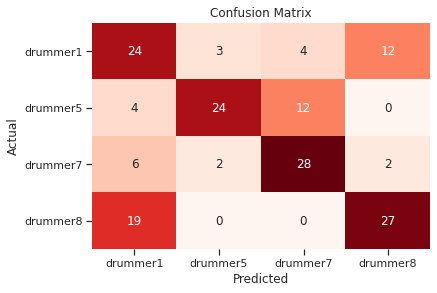


_______________________________________________________

>> NEIGBORS = 7

KNN Accuracy score...
  KNN: 0.6107784431137725

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.49      0.57      0.53        46
    drummer5       0.83      0.59      0.69        41
    drummer7       0.57      0.74      0.64        34
    drummer8       0.66      0.59      0.62        46

    accuracy                           0.61       167
   macro avg       0.64      0.62      0.62       167
weighted avg       0.64      0.61      0.61       167


Confusion matrix...


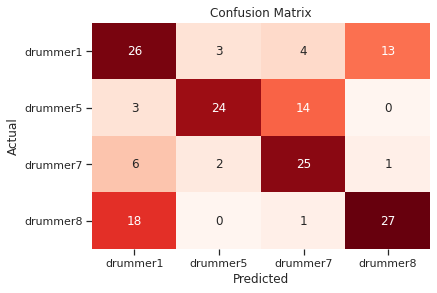


_______________________________________________________

>> NEIGBORS = 9

KNN Accuracy score...
  KNN: 0.6107784431137725

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.53      0.58      0.55        48
    drummer5       0.86      0.61      0.71        41
    drummer7       0.55      0.75      0.63        32
    drummer8       0.61      0.54      0.57        46

    accuracy                           0.61       167
   macro avg       0.64      0.62      0.62       167
weighted avg       0.64      0.61      0.61       167


Confusion matrix...


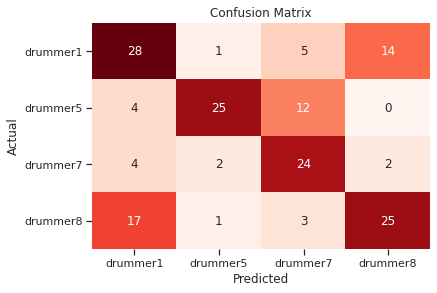

In [58]:
print("\n_______________________________________________________")
print("\n>> NEIGBORS = 5")
KNN_results(KNN_prediction_5, y_test, np.unique(y))
c_matrix(KNN_prediction_5, y_test, np.unique(y))

print("\n_______________________________________________________")
print("\n>> NEIGBORS = 7")
KNN_results(KNN_prediction_7, y_test, np.unique(y))
c_matrix(KNN_prediction_7, y_test, np.unique(y))

print("\n_______________________________________________________")
print("\n>> NEIGBORS = 9")
KNN_results(KNN_prediction_9, y_test, np.unique(y))
c_matrix(KNN_prediction_9, y_test, np.unique(y))

# Linear SVC
Another possibly useful one according to the scikitlearn cheat sheet ..

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



SVC accuracy score...
  SVC: 0.5508982035928144

SVC confusion matrix...

Confusion matrix...


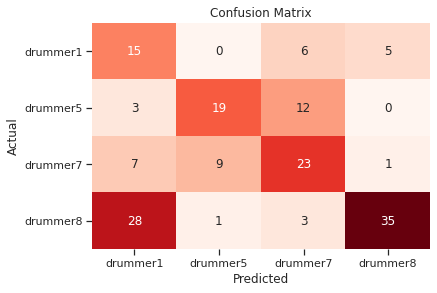

In [59]:



SVC_model = svm.SVC()
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test)

print('\n\nSVC accuracy score...')
print('  SVC: {}'.format(accuracy_score(SVC_prediction, y_test)))

print('\nSVC confusion matrix...')
# But Confusion Matrix and Classification Report give more details about performance
matrix1 = confusion_matrix(SVC_prediction, y_test)
#print(matrix1)

c_matrix(SVC_prediction, y_test, np.unique(y))



# KMeans

And maybe another to try...

### File processing code template

In [60]:
# specify style being processed
style_filter = "1_funk-groove1"  

# iterate and process
for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  df_1 = perf_data.tight_df
  if style_filter in file_name:
    print('data for: {}'.format(file_name))
  # end test loop


data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/1_funk-groove1_138_beat_4-4.mid
data for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/1_funk-groove1_138_beat_4-4.mid
